In [1]:
import torch
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import MultivariateEvaluator
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
from typing import List

sys.path.append("..")
from timefusion.utils import metrics

In [2]:
# Import dataset
train_data = pd.read_csv("../datasets/electricity/train.csv", index_col="date")
val_data = pd.read_csv("../datasets/electricity/val.csv", index_col="date")
test_data = pd.read_csv("../datasets/electricity/test.csv", index_col="date")

#train_data = train_data.iloc[:1000,:10]
#val_data = val_data.iloc[:1000,:10]
#test_data = test_data.iloc[:1000,:10]

# Normalize the signal power of each column
stds = train_data.std()
train_data /= stds
val_data /= stds
test_data /= stds

In [3]:
context_length = 48
prediction_length = 24

# Convert data into a glounts ListDataset
def get_dataset(df: pd.DataFrame, freq: str = "h", indices: List[int] = [-1]) -> ListDataset:
    return ListDataset(
        [
            {
                "start": df.index[0],
                "target": df.values[:i].T,
            }
            for i in indices
        ],
        freq=freq,
        one_dim_target=False
    )

train_dataset = get_dataset(train_data)
val_dataset = get_dataset(val_data)
test_dataset = get_dataset(test_data, indices=list(range(test_data.shape[0], test_data.shape[0] - 14*prediction_length, -prediction_length)))


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
estimator = TransformerTempFlowEstimator(
    d_model=16,
    num_heads=4,
    input_size=1280,
    target_dim=train_data.shape[1],
    prediction_length=prediction_length,
    context_length=context_length,
    flow_type='RealNVP',
    dequantize=True,
    freq="h",
    trainer=Trainer(
        device=device,
        epochs=2,
        learning_rate=1e-3,
        num_batches_per_epoch=100,
        batch_size=64,
    ),
)

In [11]:
# Train model
predictor = estimator.train(train_dataset,num_workers=2)

print("hello")

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x151dcc68e310>
Traceback (most recent call last):
  File "/rds/general/user/ejh19/home/Final-Year-Project/transformer_maf/.venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/rds/general/user/ejh19/home/Final-Year-Project/transformer_maf/.venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/rds/general/user/ejh19/home/.conda/envs/py38/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x151dcc68e310>
Traceback (most recent call last):
  File "/rds/general/user/ejh19/home/Final-Year-Project/transformer_maf/.venv/lib/python3.8/site-packages/torch/utils/data/data

hello


In [12]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_dataset,
    predictor=predictor,
    num_samples=128
)

samples = list(forecast_it)
realisations = list(ts_it)


In [8]:
samples = torch.tensor([sample.samples for sample in samples]).permute(0,1,3,2)
realisations = torch.tensor([real.values[-prediction_length:] for real in realisations]).permute(0,2,1)

/var/tmp/pbs.7698056.pbs/ipykernel_2607307/1595039056.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  samples = torch.tensor([sample.samples for sample in samples]).permute(0,1,3,2)


In [9]:
samples

tensor([[[[ 2.4230e+00,  1.1367e+00,  5.0471e-01,  ...,  8.4929e-01,
            1.2399e+00,  6.7800e-01],
          [ 3.8689e+00,  3.6083e+00,  4.2880e+00,  ...,  4.9755e+00,
            4.2991e+00,  5.0451e+00],
          [-1.8018e-01,  1.2388e+00,  6.3228e-01,  ...,  1.3715e-01,
            2.8558e-01,  7.8536e-01],
          ...,
          [ 4.9556e+00,  4.5714e+00,  6.5522e+00,  ...,  4.4440e+00,
            3.9192e+00,  3.3401e+00],
          [ 5.0474e+00,  2.5243e+00,  3.8667e+00,  ...,  7.4792e-01,
            1.5479e+00,  1.4283e+00],
          [ 7.5043e+00,  5.5742e+00,  6.8560e+00,  ...,  6.0825e+00,
            6.0464e+00,  5.9738e+00]],

         [[ 1.1584e+00,  2.3606e+00,  5.2918e-01,  ...,  8.1418e-01,
            6.7968e-01,  1.2097e+00],
          [ 4.8184e+00,  3.3015e+00,  1.9612e+00,  ...,  4.3503e+00,
            4.7161e+00,  3.2197e+00],
          [ 9.0471e-01,  6.3937e-01,  4.4752e-01,  ...,  7.6458e-01,
            4.6902e-01,  2.7459e-01],
          ...,
     

In [20]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:],
                                  target_agg_funcs={'sum': np.sum})

In [21]:

forecast_it, ts_it = make_evaluation_predictions(dataset=test_dataset,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

agg_metric, _ = evaluator(targets, forecasts, num_series=len(test_dataset))

/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv

In [22]:

print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.23590589924365937
ND: 0.2828768642474405
NRMSE: 0.3704165257077077
MSE: 0.6444251158335689


In [23]:
len(forecasts)

14

In [24]:
forecasts[0].samples.shape

(100, 24, 10)

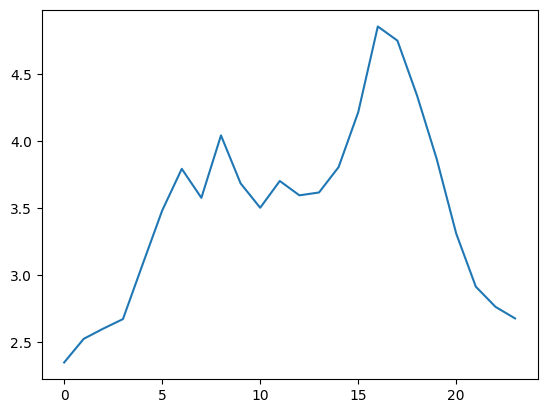

In [36]:
plt.plot(np.mean(forecasts[0].samples,axis=0)[:,7])

In [31]:
np.mean(forecasts[0].samples,axis=0)[:,1]

(24, 10)

In [ ]:
forecasts[]